# Super Resolution

## Step1 - Creating the  dataset 

Our basic dataset for this task will be the PascalVOC 2007 dataset 
It can be found here: https://drive.google.com/open?id=1mVdwSAEaFTAUWvJYb-17knUhBeoXJ8AW 
we will create a dataset with images of 3 different sizes:
X - 72x72x3 
y_mid – 144x144x3 
y_large – 288x288x3

Next, we will present a few images for verifying that we have got the input we want.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.layers import Dense, Conv2D, Flatten, Input, AvgPool2D,MaxPool2D,Dropout,BatchNormalization, add, concatenate, Lambda

from keras.layers import Flatten, Dense, LSTM, Input, Dropout, BatchNormalization,UpSampling2D, Activation
from keras.models import Model, Sequential


Using TensorFlow backend.


In [0]:
import cv2
import os

Here we are resizing each photo for 72,144 or 288 in order to create a dataset with same dimensions for our network to train on

In [0]:
X = []
y_mid = []
y_large = []

In [0]:
def add_images(dir):
    for filename in os.listdir(dir)[:2500]:
        img = cv2.imread(dir + '/' + filename)
        img = img[:,:,::-1]
        X.append(cv2.resize(img, (72,72)))
        y_mid.append(cv2.resize(img, (144,144)))
        y_large.append(cv2.resize(img, (288,288)))
    

In [0]:
dir = 'drive/My Drive/VOC2007/JPEGImages'

In [0]:
add_images(dir)

In [0]:
X = np.array(X) / 255
y_mid = np.array(y_mid) / 255
y_large = np.array(y_large) / 255

In [0]:
x_train = X[:2000]
x_val = X[2000:]
y_mid_train = y_mid[:2000]
y_mid_val = y_mid[2000:]

In [0]:
y_large_train = y_large[:2000]
y_large_val = y_large[2000:]

Lets plot samples from each dataset to understand the difference between them 

In [0]:
def show_images(images):
    for image in images:
        ax = plt.figure(figsize = (17,6)).add_subplot(131)
        plt.axis('off')
        plt.grid(False)
        plt.imshow(X[image],aspect='auto')
        plt.subplot(132)
        plt.axis('off')
        plt.grid(False)
        plt.imshow(y_mid[image],aspect='auto')
        plt.subplot(133)
        plt.axis('off')
        plt.grid(False)
        plt.imshow(y_large[image],aspect='auto')

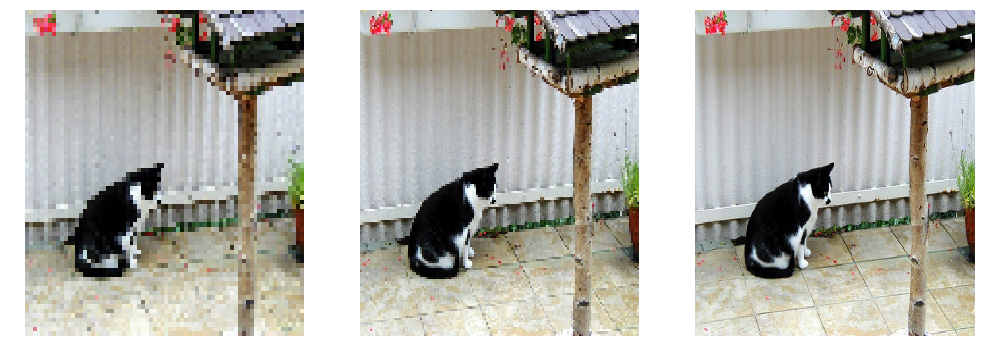

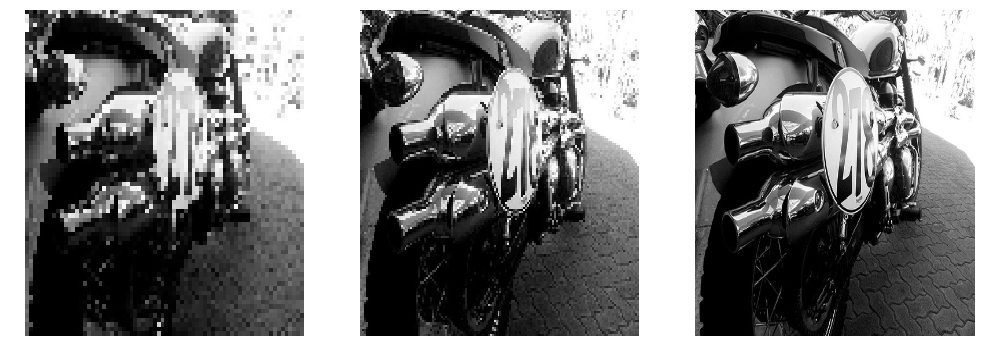

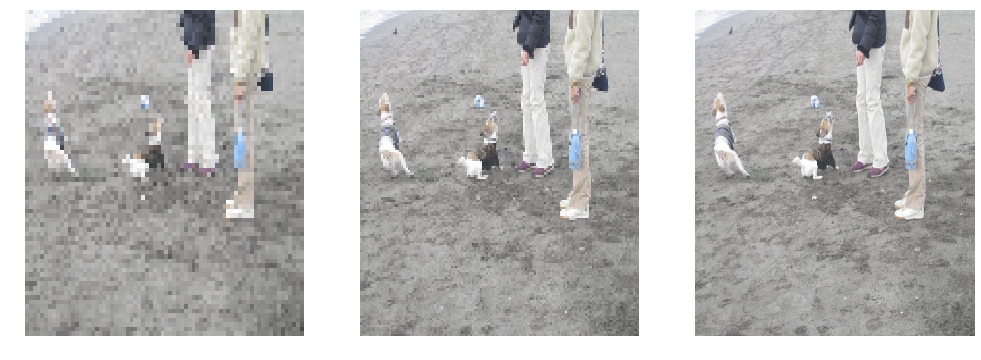

In [0]:
show_images(range(2103,2106))

In [0]:
def compare_images(small_image, predictions,label_image):
    for small,pred,label in zip(small_image,predictions,label_image):  
        plt.figure(figsize = (17,7)).add_subplot(131)
        plt.axis('off')
        plt.grid(False)
        plt.imshow(small,aspect='auto')
        plt.subplot(132)
        plt.axis('off')
        plt.grid(False)
        plt.imshow(pred,aspect='auto')
        plt.subplot(133)
        plt.axis('off')
        plt.grid(False)
        plt.imshow(label,aspect='auto')
        
      

## Step 2 - Simple Fully convoltional net with UpSampling

In [0]:

inp = Input(shape=(None,None,3))
x = Conv2D(64, (1,1),activation='relu',input_shape=(None,None,3))(inp)
x = Conv2D(64, (1,1),activation='relu')(x)
x = UpSampling2D()(x)
out = Conv2D(3, (1,1))(x)
model1 = Model(inputs=inp, outputs=out)

model1.compile(loss='mean_squared_error',optimizer='adam')

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
model1.fit(x_train, y_mid_train, epochs=5)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
2000/2000 [==============================] - 7s 4ms/step - loss: 0.0575
Epoch 2/5
2000/2000 [==============================] - 4s 2ms/step - loss: 0.0093
Epoch 3/5
2000/2000 [==============================] - 4s 2ms/step - loss: 0.0090
Epoch 4/5
2000/2000 [==============================] - 4s 2ms/step - loss: 0.0090
Epoch 5/5
2000/2000 [==============================] - 4s 2ms/step - loss: 0.0090


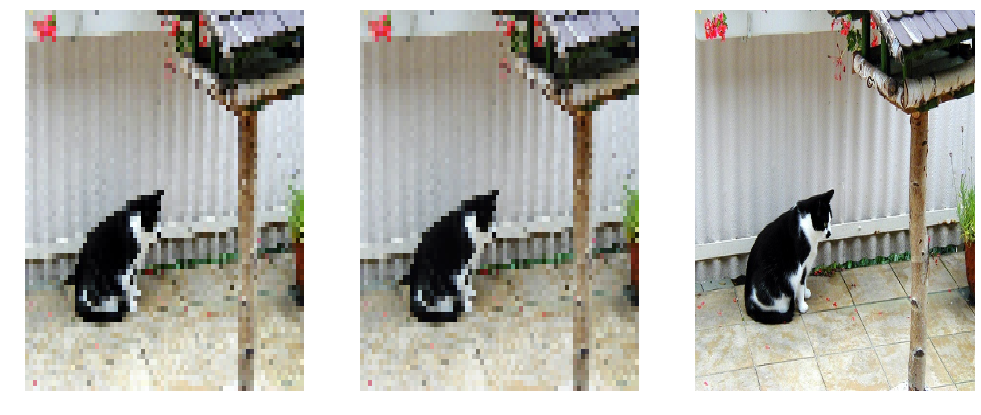

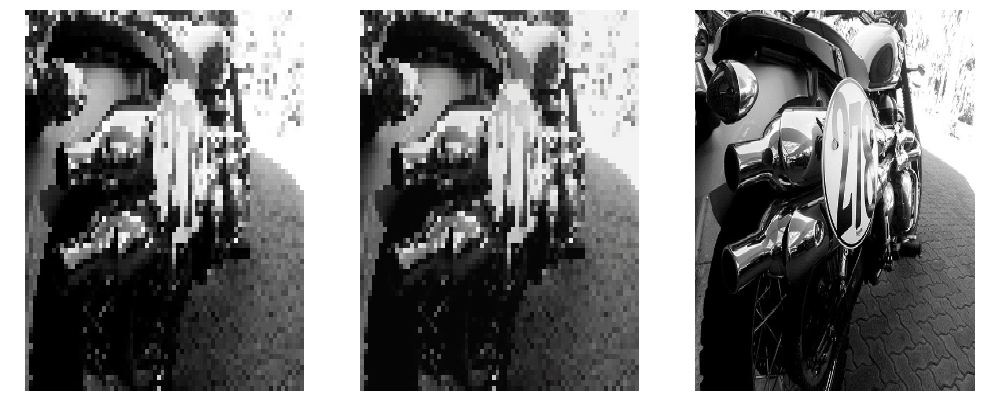

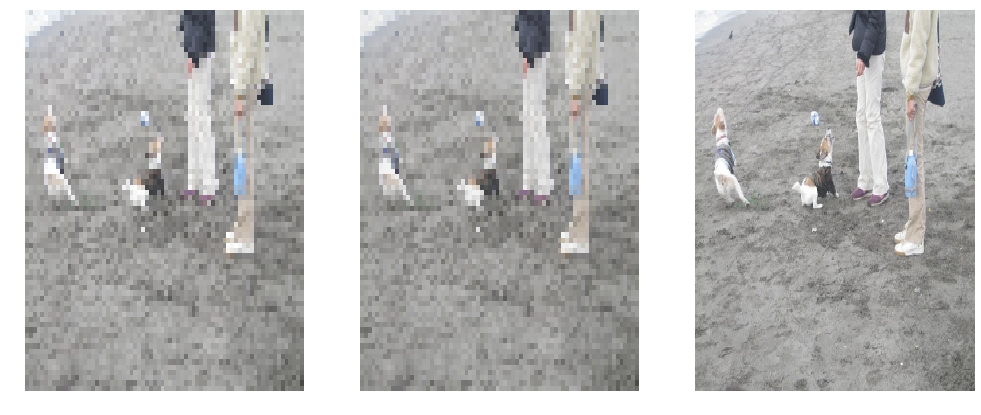

In [0]:
pred = model1.predict(x_val[103:106])

compare_images(X[2103:2106], pred, y_large[2103:2106])

## Step 3 - Fully convoltional net with UpSampling and another output block

In [0]:
inp = Input(shape=(None,None,3))
x = Conv2D(64, (1,1),activation='relu',input_shape=(None,None,3))(inp)
x = Conv2D(64, (1,1),activation='relu')(x)
x = UpSampling2D()(x)
outMid = Conv2D(3, (1,1))(x)

x = UpSampling2D()(outMid)
outLarge = Conv2D(3, (1,1))(x)
model2 = Model(inputs=inp, outputs=[outMid, outLarge])

model2.compile(loss='mean_squared_error',optimizer='adam')

In [0]:
history = model2.fit(x_train, [y_mid_train,y_large_train], epochs=20)

Epoch 1/20
2000/2000 [==============================] - 9s 5ms/step - loss: 0.3882 - conv2d_17_loss: 0.0869 - conv2d_18_loss: 0.3013
Epoch 2/20
2000/2000 [==============================] - 9s 4ms/step - loss: 0.2758 - conv2d_17_loss: 0.0443 - conv2d_18_loss: 0.2314
Epoch 3/20
2000/2000 [==============================] - 9s 4ms/step - loss: 0.1911 - conv2d_17_loss: 0.0360 - conv2d_18_loss: 0.1551
Epoch 4/20
2000/2000 [==============================] - 9s 4ms/step - loss: 0.1349 - conv2d_17_loss: 0.0349 - conv2d_18_loss: 0.0999
Epoch 5/20
2000/2000 [==============================] - 9s 4ms/step - loss: 0.1013 - conv2d_17_loss: 0.0340 - conv2d_18_loss: 0.0673
Epoch 6/20
2000/2000 [==============================] - 9s 4ms/step - loss: 0.0810 - conv2d_17_loss: 0.0318 - conv2d_18_loss: 0.0492
Epoch 7/20
2000/2000 [==============================] - 9s 4ms/step - loss: 0.0678 - conv2d_17_loss: 0.0288 - conv2d_18_loss: 0.0391
Epoch 8/20
2000/2000 [==============================] - 9s 4ms/step -

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


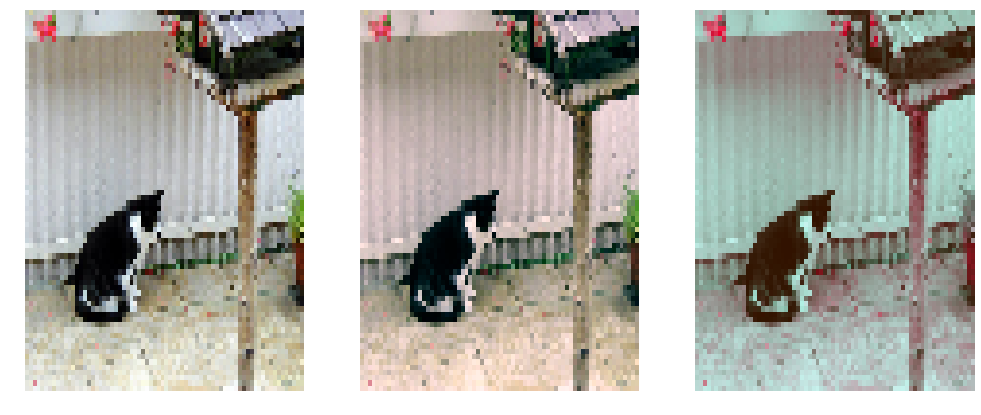

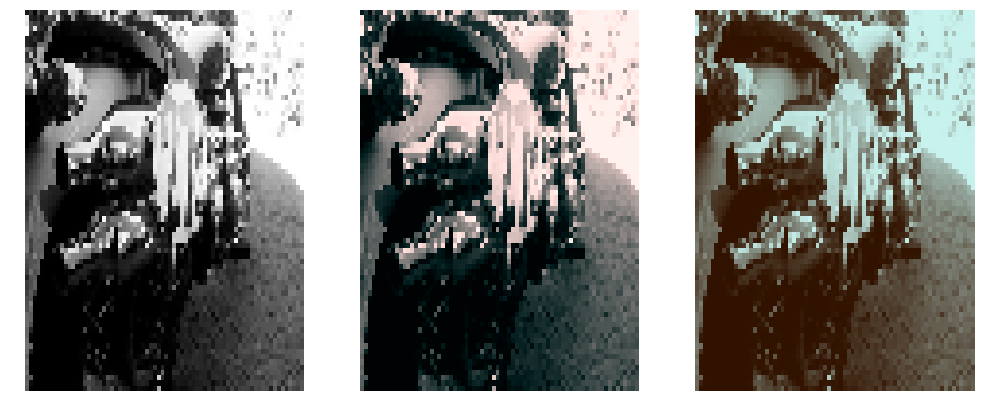

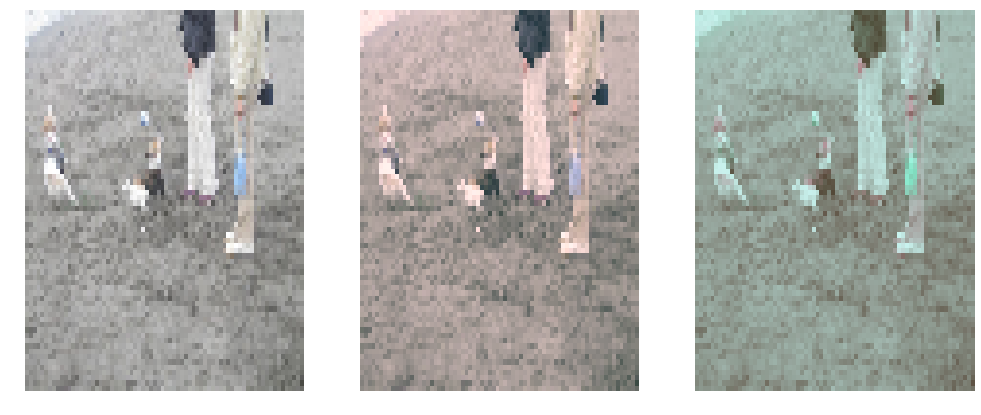

In [0]:
pred_mid, pred_large= model2.predict(x_val[103:106])

compare_images(X[2103:2106], pred_mid, pred_large)

## Step 4 - Adding Residual Block

In [0]:
def resBlock(inLayer,numOfFilters, filterSize):
    res = inLayer
    x = Conv2D(numOfFilters, filterSize,activation='relu',padding = 'same')(inLayer)
    x = Conv2D(numOfFilters, filterSize,activation='relu',padding = 'same')(x)
    x = add([res,x])
    x = Activation('relu')(x)
    return x

In [0]:

inp = Input(shape=(None,None,3))
x = Conv2D(32, (1,1),activation='relu',input_shape=(None,None,3))(inp)

x = resBlock(x,32,(3,3))
x = UpSampling2D()(x)
outMid = Conv2D(3, (1,1))(x)

x = resBlock(outMid,3,(1,1))
x = UpSampling2D()(x)
outLarge = Conv2D(3, (1,1))(x)
model4 = Model(inputs=inp, outputs=[outMid, outLarge])

model4.compile(loss='mean_squared_error',optimizer='adam')

In [0]:
history = model4.fit(x_train, [y_mid_train,y_large_train], epochs=30)

Epoch 1/30
2000/2000 [==============================] - 11s 6ms/step - loss: 0.0736 - conv2d_22_loss: 0.0222 - conv2d_25_loss: 0.0514
Epoch 2/30
2000/2000 [==============================] - 10s 5ms/step - loss: 0.0272 - conv2d_22_loss: 0.0115 - conv2d_25_loss: 0.0157
Epoch 3/30
2000/2000 [==============================] - 10s 5ms/step - loss: 0.0201 - conv2d_22_loss: 0.0093 - conv2d_25_loss: 0.0109
Epoch 4/30
2000/2000 [==============================] - 10s 5ms/step - loss: 0.0182 - conv2d_22_loss: 0.0084 - conv2d_25_loss: 0.0097
Epoch 5/30
2000/2000 [==============================] - 10s 5ms/step - loss: 0.0175 - conv2d_22_loss: 0.0082 - conv2d_25_loss: 0.0093
Epoch 6/30
2000/2000 [==============================] - 10s 5ms/step - loss: 0.0171 - conv2d_22_loss: 0.0081 - conv2d_25_loss: 0.0090
Epoch 7/30
2000/2000 [==============================] - 10s 5ms/step - loss: 0.0169 - conv2d_22_loss: 0.0080 - conv2d_25_loss: 0.0089
Epoch 8/30
2000/2000 [==============================] - 9s 5ms

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


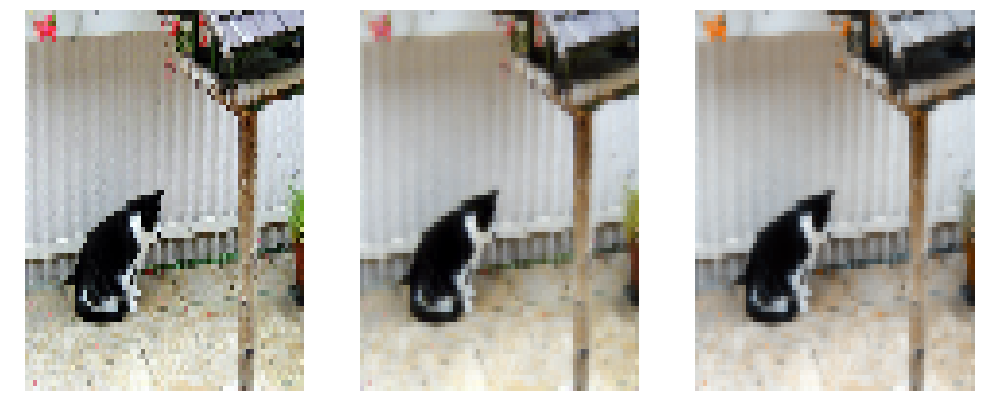

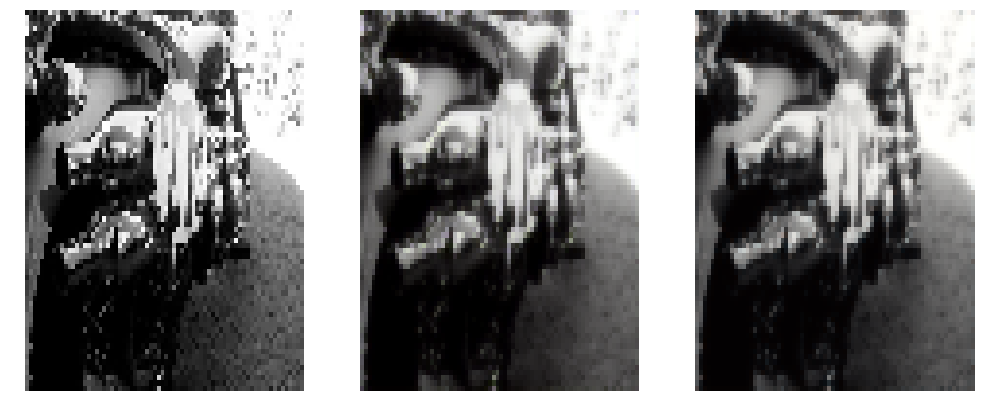

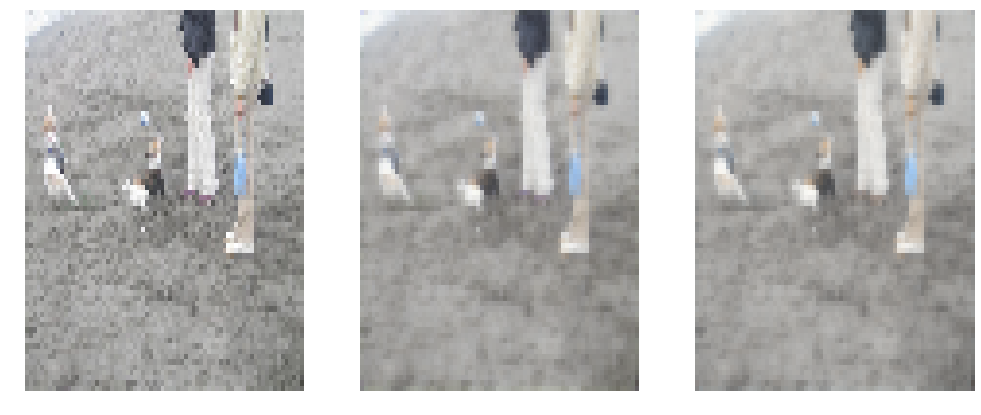

In [0]:
pred_mid, pred_large= model4.predict(x_val[103:106])

compare_images(X[2103:2106], pred_mid, pred_large)

## Step 5 - Adding  VGG16 feature extractor to the network

In [0]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np


In [12]:
VGG16model = VGG16(weights='imagenet', include_top=False)


Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 2s 0us/step


In [0]:
vggConv2 = VGG16model.get_layer('block1_conv2')

In [0]:
model_vggEX = Model(VGG16model.input, vggConv2.output)

for l in model_vggEX.layers: 
    l.trainable=False

In [0]:
inp = Input(shape=(None,None,3))
x = concatenate([inp, model_vggEX(inp)],axis=3)
x = Conv2D(64, (1,1),activation='relu',input_shape=(None,None,3))(x)
x = Conv2D(64, (1,1),activation='relu',input_shape=(None,None,3))(x)


x = resBlock(x,64,(3,3))
x = UpSampling2D()(x)
outMid = Conv2D(3, (1,1))(x)

x = resBlock(outMid,3,(1,1))
x = UpSampling2D()(x)
outLarge = Conv2D(3, (1,1))(x)
model5 = Model(inputs=inp, outputs=[outMid, outLarge])

model5.compile(loss='mean_squared_error',optimizer='adam')

In [0]:
history = model5.fit(x_train, [y_mid_train,y_large_train], epochs=30)

Epoch 1/30
2000/2000 [==============================] - 14s 7ms/step - loss: 0.7680 - conv2d_30_loss: 0.4609 - conv2d_33_loss: 0.3071
Epoch 2/30
2000/2000 [==============================] - 13s 7ms/step - loss: 0.1927 - conv2d_30_loss: 0.0987 - conv2d_33_loss: 0.0940
Epoch 3/30
2000/2000 [==============================] - 13s 7ms/step - loss: 0.1319 - conv2d_30_loss: 0.0701 - conv2d_33_loss: 0.0617
Epoch 4/30
2000/2000 [==============================] - 13s 7ms/step - loss: 0.0978 - conv2d_30_loss: 0.0530 - conv2d_33_loss: 0.0448
Epoch 5/30
2000/2000 [==============================] - 13s 7ms/step - loss: 0.0749 - conv2d_30_loss: 0.0409 - conv2d_33_loss: 0.0340
Epoch 6/30
2000/2000 [==============================] - 13s 7ms/step - loss: 0.0626 - conv2d_30_loss: 0.0337 - conv2d_33_loss: 0.0289
Epoch 7/30
2000/2000 [==============================] - 13s 7ms/step - loss: 0.0515 - conv2d_30_loss: 0.0278 - conv2d_33_loss: 0.0237
Epoch 8/30
2000/2000 [==============================] - 13s 7m

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


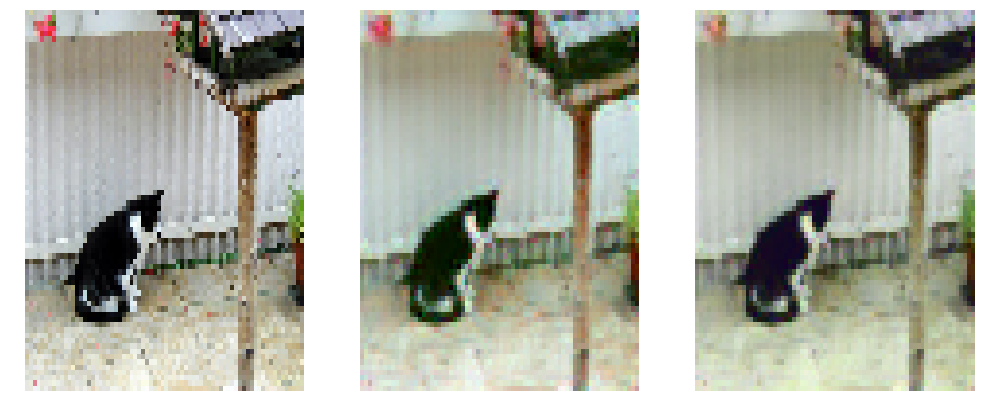

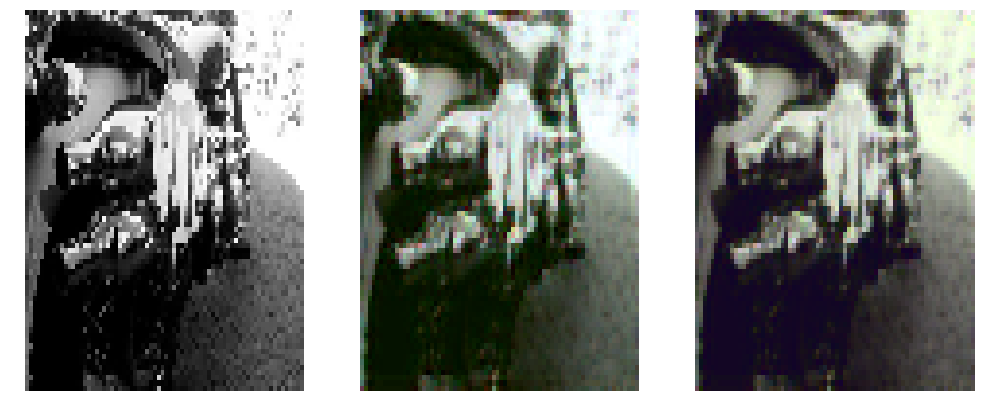

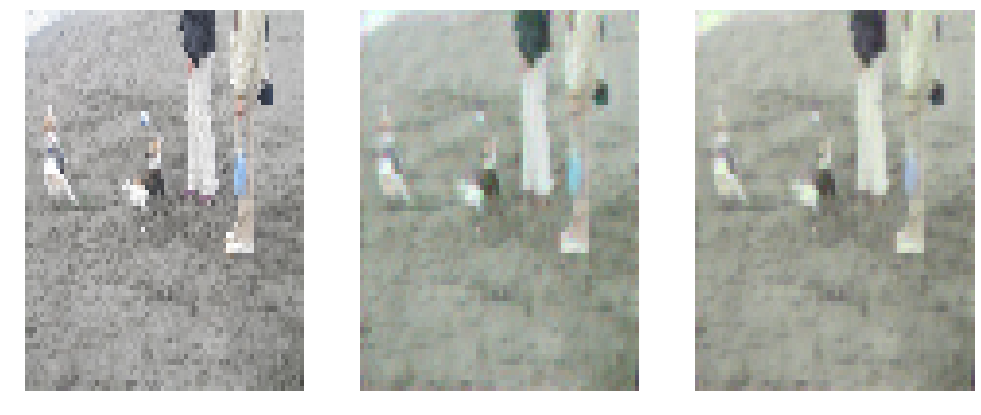

In [0]:
pred_mid, pred_large= model5.predict(x_val[103:106])

compare_images(X[2103:2106], pred_mid, pred_large)

##Step 6 -  replacing Upsampling2D with SubPixelConv2D

In [0]:
import tensorflow as tf

def SubPixelConv2D(scale, **kwargs):
    return Lambda(lambda x: tf.depth_to_space(x,scale), **kwargs)


inp = Input(shape=(None,None,3))
x = concatenate([inp, model_vggEX(inp)],axis=3)
x = Conv2D(64, (1,1),activation='relu',padding = 'same')(x)
x = Conv2D(64, (1,1),activation='relu',padding = 'same')(x)


x = resBlock(x,64,(3,3))
# x = UpSampling2D()(x)
x = SubPixelConv2D(2)(x)
outMid = Conv2D(3, (1,1))(x)

x = resBlock(x,16,(3,3))
# x = UpSampling2D()(x)
x = SubPixelConv2D(2)(x)
outLarge = Conv2D(3, (1,1))(x)
model6 = Model(inputs=inp, outputs=[outMid, outLarge])

model6.compile(loss='mean_squared_error',optimizer='adam')



    

In [26]:
history = model6.fit(x_train, [y_mid_train,y_large_train], epochs=30)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
2000/2000 [==============================] - 16s 8ms/step - loss: 1.1179 - conv2d_29_loss: 0.3650 - conv2d_32_loss: 0.7529
Epoch 2/30
2000/2000 [==============================] - 13s 6ms/step - loss: 0.0792 - conv2d_29_loss: 0.0301 - conv2d_32_loss: 0.0492
Epoch 3/30
2000/2000 [==============================] - 13s 6ms/step - loss: 0.0381 - conv2d_29_loss: 0.0162 - conv2d_32_loss: 0.0219
Epoch 4/30
2000/2000 [==============================] - 13s 6ms/step - loss: 0.0306 - conv2d_29_loss: 0.0134 - conv2d_32_loss: 0.0172
Epoch 5/30
2000/2000 [==============================] - 13s 6ms/step - loss: 0.0265 - conv2d_29_loss: 0.0117 - conv2d_32_loss: 0.0148
Epoch 6/30
2000/2000 [==============================] - 13s 6ms/step - loss: 0.0240 - conv2d_29_loss: 0.0108 - conv2d_32_loss: 0.0132
Epoch 7/30
2000/2000 [==============================] - 13s 6ms/step - loss: 0.0223 - conv2d_29_loss: 0.0102 - conv2d_32_loss: 0.0121
Epoch 8/30
200

##Results:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


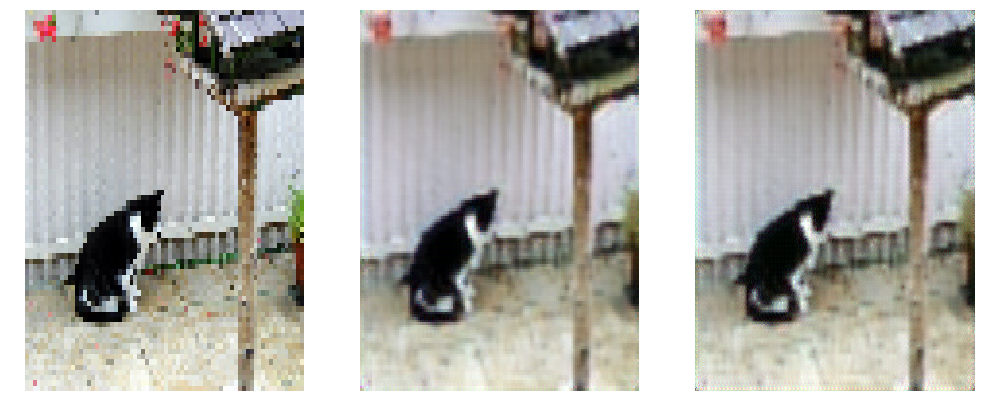

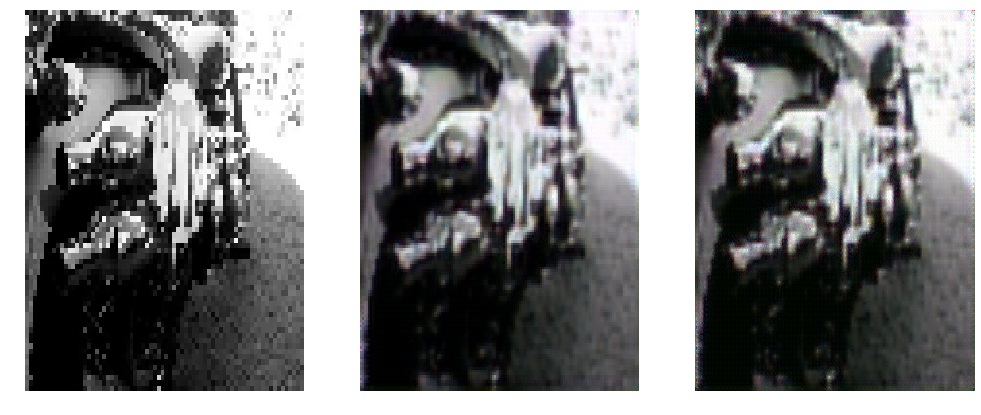

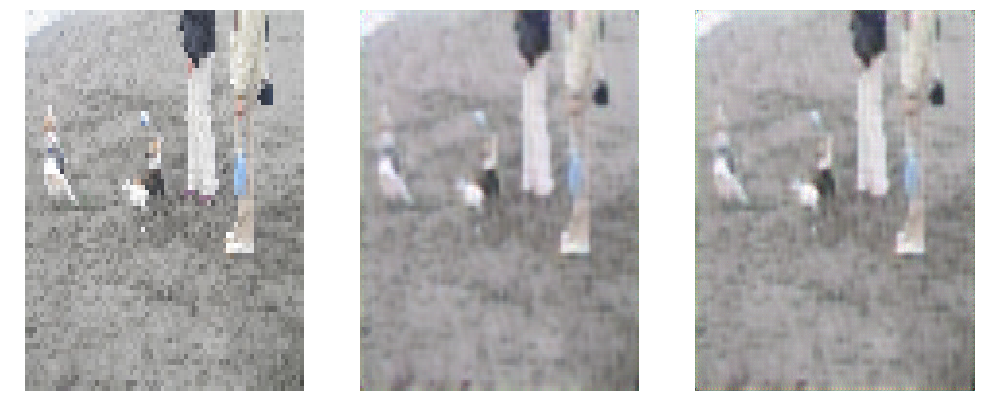

In [29]:
pred_mid, pred_large= model6.predict(x_val[103:106])

compare_images(X[2103:2106], pred_mid, pred_large)

We can see an improvement in both mid and large pictures